In [153]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from timeit import default_timer as timer

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder 

from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras import layers, models
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout, Reshape
from keras.optimizers import Adam
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose

In [154]:
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
working_path = os.path.join(parent_dir) #incase directory needs to be expanded
downloads_path = os.path.expanduser("~\\Downloads")
extract_dir = os.path.expanduser("~\\Data_science")

In [155]:
# Set up folder paths
# Define the source paths for images and annotations
image_pool_path = os.path.join(extract_dir, 'VOC_PCB', 'JPEGImages')
annot_pool_path = os.path.join(extract_dir, 'VOC_PCB', 'Annotations')

# Define the destination path for images and annotations
image_dest_path = os.path.join(working_path, 'data', 'Images')
annot_dest_path = os.path.join(working_path, 'data', 'Annotations')

# Define the destination path for bboxes and masks
bb_path = os.path.join(working_path, 'data', 'Images_bb')
mask_path = os.path.join(working_path, 'data', 'Pixel_masks')

# Define the destination path for csv file
csv_path = os.path.join(working_path, 'data', 'csv')

In [156]:
image_dataset_path = image_dest_path

In [157]:
csv_bounding_boxes = (f'{csv_path}\\PCB_annotations_dataset.csv')
images = os.listdir(image_dataset_path)

In [158]:
df = pd.read_csv(csv_bounding_boxes, sep=";")

In [159]:
bounding_boxes_data = pd.read_csv(csv_bounding_boxes, sep=";")

image_data = []
class_labels = []
mask_data= []

grouped_bbox = bounding_boxes_data.groupby('filename')

In [160]:
image_data = []
mask_data = []
class_labels = []

for filename in images:
   
    image_path = os.path.join(image_dataset_path, filename)
    
    image = cv2.imread(image_path)
    image = cv2.resize(image, (600, 600))  
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_array = np.asarray(gray_image) / 255.0 
    image_data.append(image_array)

    filename = os.path.splitext(filename)[0]
        
    mask = np.zeros((600, 600), dtype=np.uint8)

    if filename in grouped_bbox.groups:
        image_bbox_df = grouped_bbox.get_group(filename)

        for index, row in image_bbox_df.iterrows():
            class_label = row['defect']
        
            xmin, ymin, xmax, ymax = [int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])] 
            #mask_color = class_to_color[class_label]
            mask[ymin:ymax, xmin:xmax] = 255 #mask_color 
    
    mask = np.asarray(mask) / 255.0

    mask_array = np.asarray(mask)
            
    mask_data.append(mask_array)
    
    class_labels.append(class_label)

X_images = np.array(image_data)
y_bounding_boxes = np.array(mask_data)
y_class_labels = np.array(class_labels)

# class_label_mapping = {label: index for index, label in enumerate(np.unique(class_labels))}
# y_class_labels_numeric = np.array([class_label_mapping[label] for label in class_labels])

# num_classes = len(class_label_mapping)
# y_categorical = to_categorical(y_class_labels_numeric, num_classes=num_classes)


In [161]:
print(X_images.shape)
print(y_bounding_boxes.shape)
print(y_class_labels.shape)

(597, 600, 600)
(597, 600, 600)
(597,)


In [162]:
new_size = (200, 200)

cropped_images_int = []
cropped_masks_int = []
cropped_y_class_labels_int = []

threshold = 130  

for image, mask, labels in zip(X_images, y_bounding_boxes, y_class_labels):
    for y in range(0, 600, new_size[0]):
        for x in range(0, 600, new_size[0]):
            patch_image = image[y:y+new_size[0], x:x+new_size[0]]
            patch_mask = mask[y:y+new_size[0], x:x+new_size[0]]

            if np.any(patch_mask):
                if np.sum(patch_mask) > threshold:
                    cropped_images_int.append(patch_image)
                    cropped_masks_int.append(patch_mask)
                    cropped_y_class_labels_int.append(labels)
                else:
                    cropped_images_int.append(patch_image)
                    cropped_masks_int.append(patch_mask)
                    cropped_y_class_labels_int.append("none")

cropped_images_int = np.array(cropped_images_int)
cropped_masks_int = np.array(cropped_masks_int)
cropped_y_class_labels = np.array(cropped_y_class_labels_int)

print(cropped_images_int.shape)
print(cropped_masks_int.shape)
print(cropped_y_class_labels.shape)


(1339, 200, 200)
(1339, 200, 200)
(1339,)


In [163]:
def plot_images(images, masks, labels, num_samples=6):
    _ , axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    sample_indices = np.random.choice(len(images), num_samples, replace=False)
    
    for i, idx in enumerate(sample_indices):
        axes[i].imshow(images[idx], cmap='gray')
        axes[i].imshow(masks[idx], alpha=0.5, cmap='jet')
        axes[i].set_title(f'Label: {labels[idx]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()



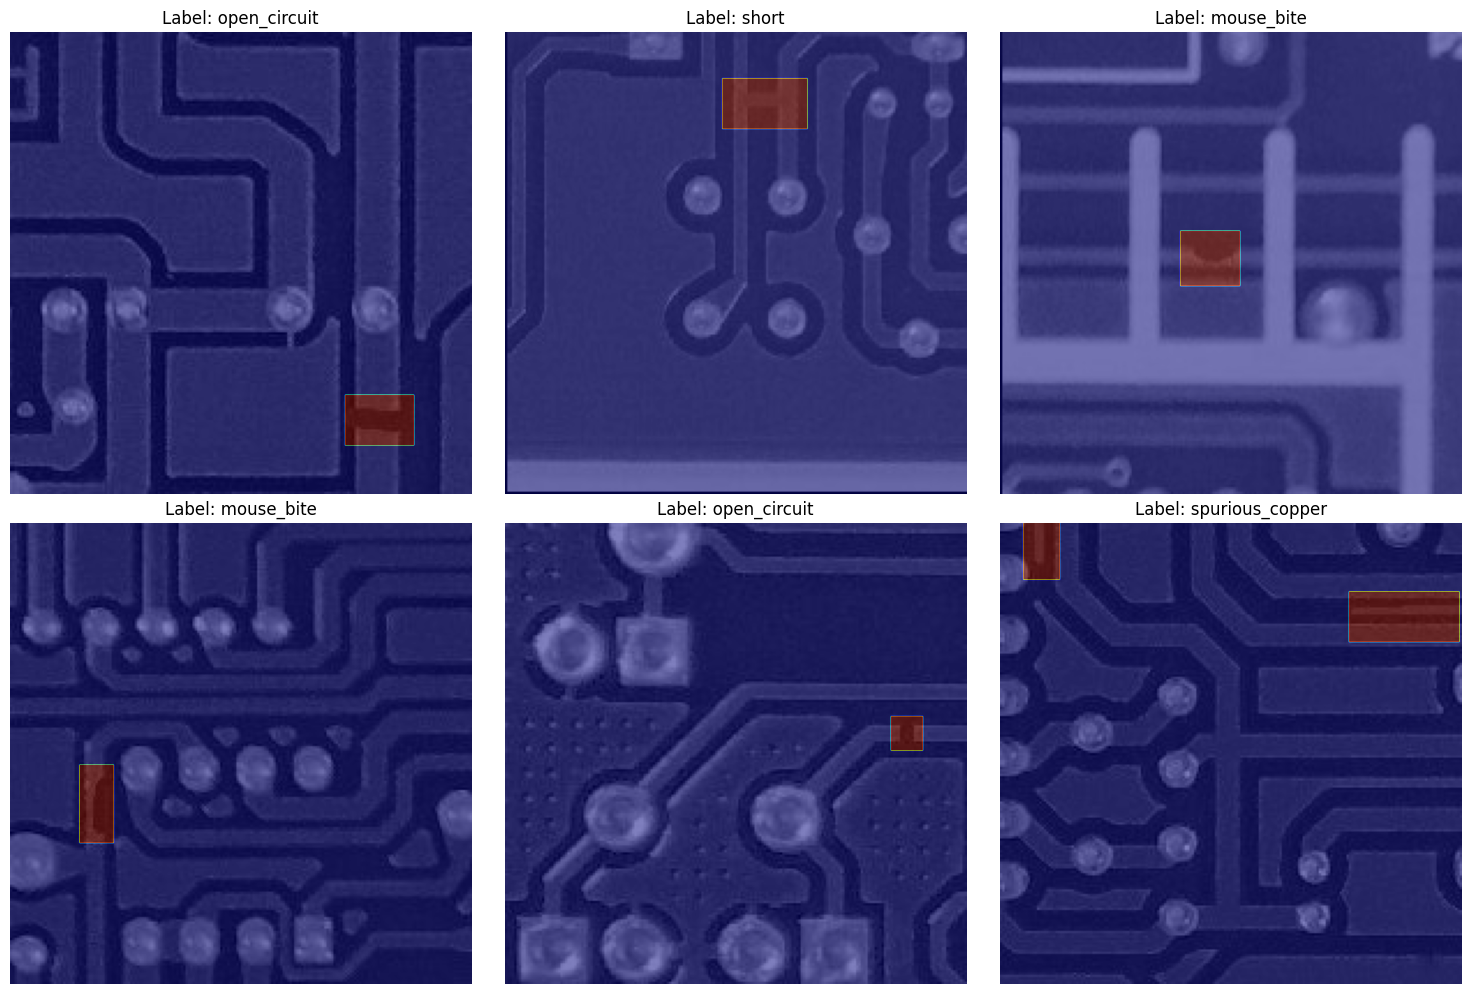

In [169]:
# Plot random 6 images
plot_images(cropped_images_int, cropped_masks_int, cropped_y_class_labels)

In [165]:
encoder = LabelEncoder()

y_class_labels_encoded = encoder.fit_transform(cropped_y_class_labels)
cropped_y_categorical = to_categorical(y_class_labels_encoded)

In [118]:
unique_labels, label_counts = np.unique(cropped_y_class_labels, return_counts=True)

for label, count in zip(unique_labels, label_counts):
    print(f"Label: {label}, Count: {count}")

Label: missing_hole, Count: 24
Label: mouse_bite, Count: 16
Label: none, Count: 13
Label: open_circuit, Count: 18
Label: short, Count: 18
Label: spur, Count: 13
Label: spurious_copper, Count: 29


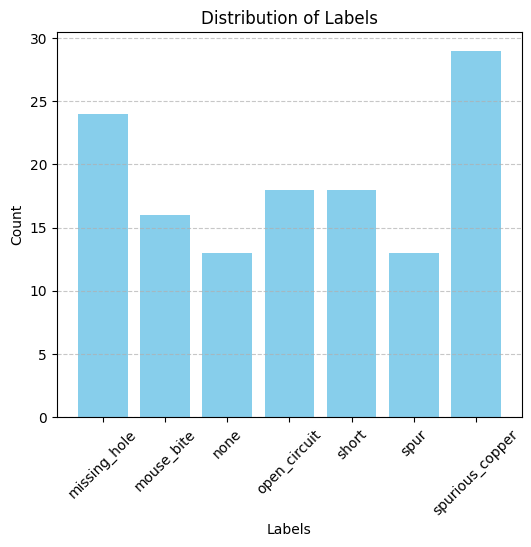

In [148]:
plt.figure(figsize=(6, 5))
plt.bar(unique_labels, label_counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

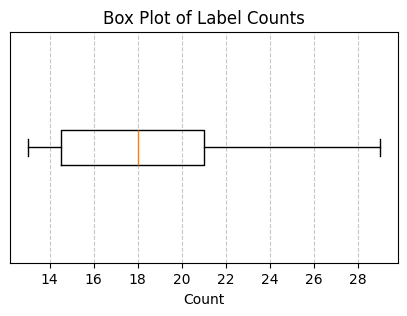

In [150]:
plt.figure(figsize=(5, 3))
plt.boxplot(label_counts, vert=False)
plt.yticks([])
plt.xlabel('Count')
plt.title('Box Plot of Label Counts')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

The above distribution of data is clearly unbalanced, so we need to balance out the data by introducing more images to the dataset.

In [166]:
unique_labels, label_counts = np.unique(cropped_y_class_labels, return_counts=True)

for label, count in zip(unique_labels, label_counts):
    print(f"Label: {label}, Count: {count}")

Label: missing_hole, Count: 230
Label: mouse_bite, Count: 202
Label: none, Count: 64
Label: open_circuit, Count: 192
Label: short, Count: 215
Label: spur, Count: 122
Label: spurious_copper, Count: 314


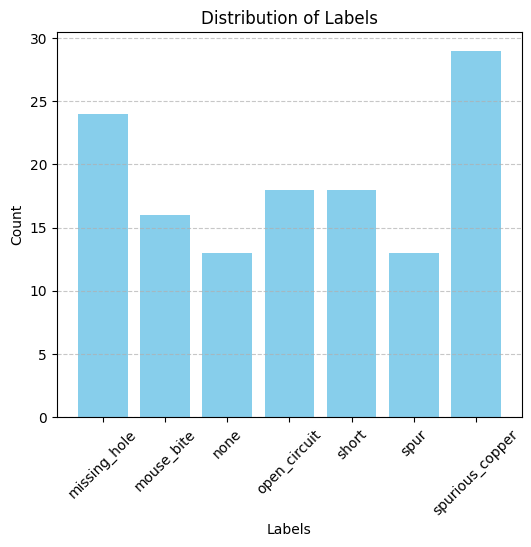

In [151]:
plt.figure(figsize=(6, 5))
plt.bar(unique_labels, label_counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

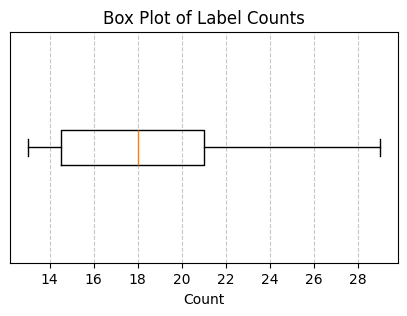

In [152]:
plt.figure(figsize=(5, 3))
plt.boxplot(label_counts, vert=False)
plt.yticks([])
plt.xlabel('Count')
plt.title('Box Plot of Label Counts')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

After including more images (along with the coresponding masks and labels) the dataset is more balanced.

In [ ]:
combined_data = []
# Combining images and masks into tuples
combined_data = list(zip(cropped_images, cropped_masks, cropped_y_categorical))